# 시계열 분석 기말 과제 12월 14일까지 제출
> 기말 과제

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [timeseries]

#### 1. 사용할 데이터 : mcopper

In [2]:
#collapse
library(fpp2)
library(astsa)
library(data.table)
library(ggplot2) 
library(gridExtra)
library(forecast)
library(portes) 
library(fUnitRoots) 
library(tseries) 
library(sarima)
library(lmtest)

##### (1) 변수변환이 필요한지를 설명하고, 필요하다면 적절한 변수 변환을 하여라.

In [180]:
#collapse
z <- as.numeric(mcopper)

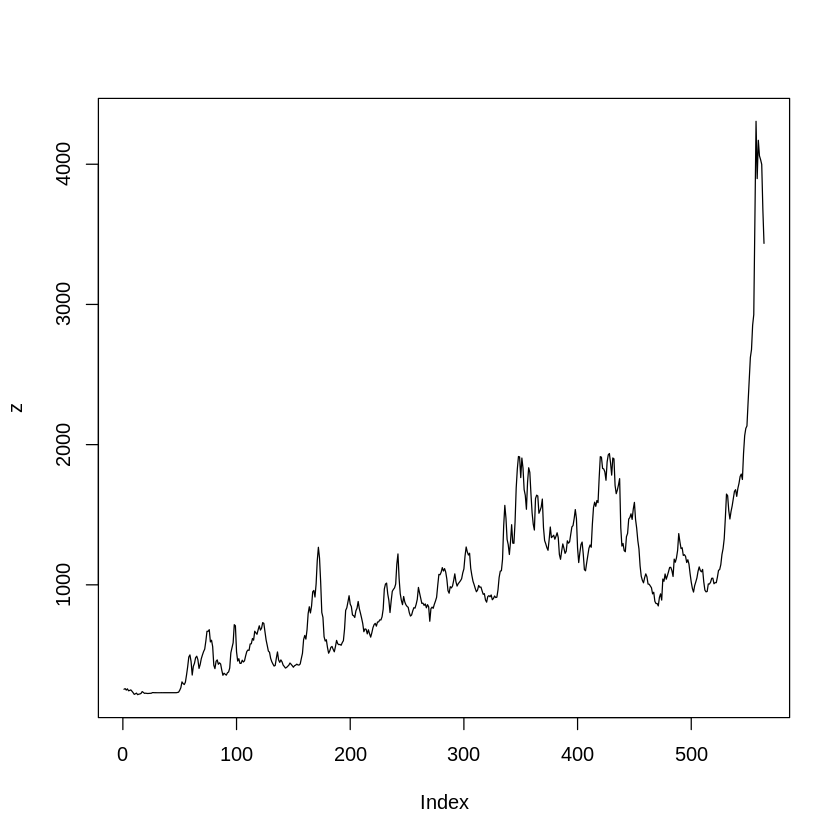

In [181]:
#collapse
plot(z, type='l')

- 분산이 일정하지 않은 모습을 보여, 심지어 커지기 때문에 변수 변환이 필요하겠다.

```R
BoxCox.lambda(z, method='loglik')
```
```
0.25
```
- 분산안정화시켜주는 람다값은 0.25가 나왔다.

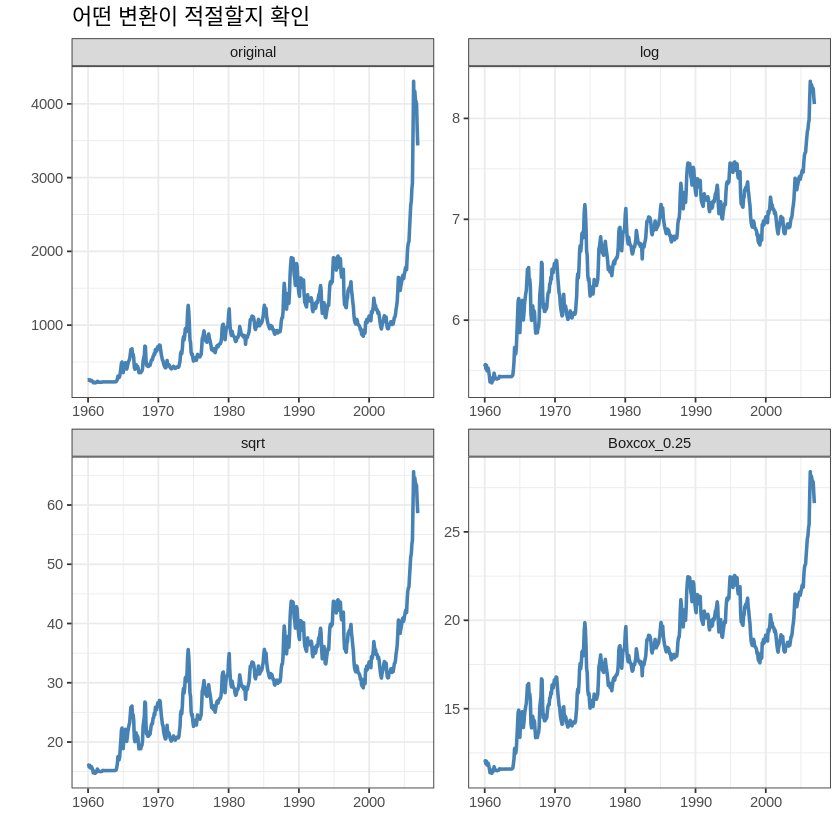

In [182]:
#collapse
tmp.dat <- data.table(
  t=seq.Date(as.Date("1960-01-01"), 
             by='month', 
             length.out=564),
  original=z,
  log = log(z),
  sqrt = sqrt(z),
  Boxcox_0.25 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("어떤 변환이 적절할지 확인")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

In [183]:
tmp.dat[, lnz:= log(z)]

- 시계열 그림을 그려보니 마지막이 독특하게 튀어나온 모습을 볼 수 있었고, 분산 안정화를 통해 정상화가 필요하겠다.
- 그림을 그려보니 trend는 모두 비슷하지만 log 변환이 가장 분산이 안정화되어 보인다.
- 그래서 log 변환을 적용했다.

##### (2) auto.arima 를 이용하여 예측 모형을 적합하여라. (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

In [184]:
auto.arima(tmp.dat$lnz, trace=T, ic='aic')


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -1555.199
 ARIMA(0,1,0) with drift         : -1485.363
 ARIMA(1,1,0) with drift         : -1543.596
 ARIMA(0,1,1) with drift         : -1556.04
 ARIMA(0,1,0)                    : -1484.453
 ARIMA(1,1,1) with drift         : -1553.325
 ARIMA(0,1,2) with drift         : -1554.063
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,1)                    : -1556.275
 ARIMA(1,1,1)                    : -1553.645
 ARIMA(0,1,2)                    : -1554.28
 ARIMA(1,1,0)                    : -1544.171
 ARIMA(1,1,2)                    : -1555.619

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,1)                    : -1561.685

 Best model: ARIMA(0,1,1)                    



Series: tmp.dat$lnz 
ARIMA(0,1,1) 

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003634:  log likelihood=782.84
AIC=-1561.69   AICc=-1561.66   BIC=-1553.02

- auto.arima를 적용해보았다.
- [ARIMA(0.1.1)(0.0.0) 모수 추정값: 0.3756] 모형이 제일 적합하다는 결론이 나와 예측 모형을 적합해 보았다.

In [186]:
fit = arima(tmp.dat$lnz, order = c(0,1,1), seasonal = list(order = c(0,0,0), period = 0))
fit


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 1), seasonal = list(order = c(0, 0, 0), 
    period = 0))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

##### (3) (2)번 모형을 제외한 다른 후보 모형을 선택하여 적합하여라. . (형태 : ARIMA(p.d.q)(P,D,Q)s , 모수 추정값)

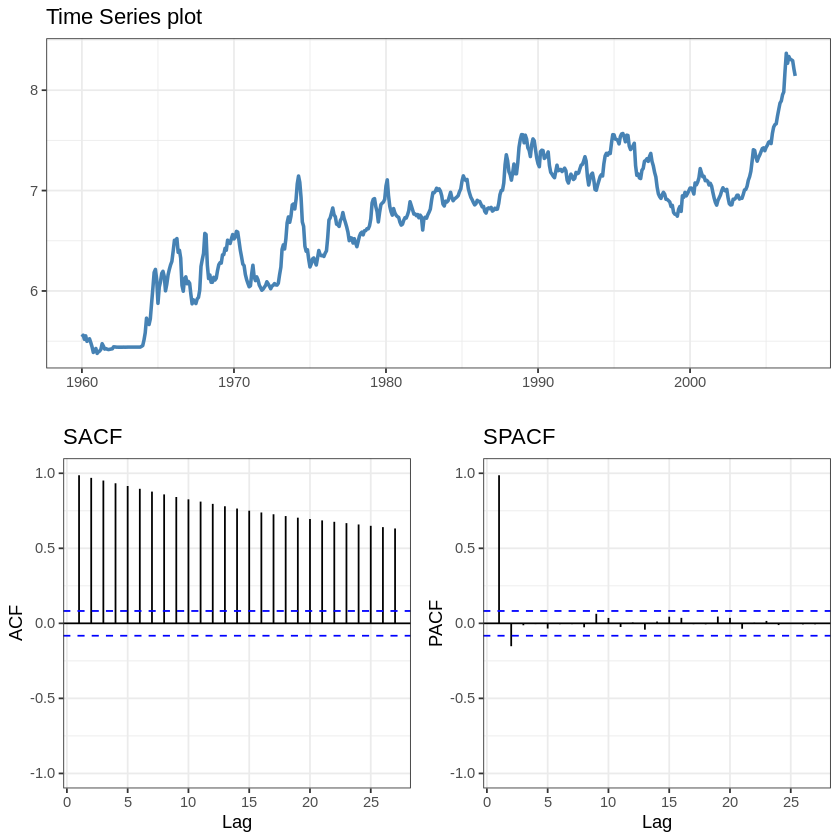

In [187]:
#collapse
p1 <- ggplot(tmp.dat, aes(t, lnz)) + geom_line(col='steelblue', lwd=1) + xlab("")+ylab("")+ ggtitle("Time Series plot")+  theme_bw()
p2 <- ggAcf(tmp.dat$lnz) +  theme_bw() + ylim(-1,1) + ggtitle("SACF")
p3 <- ggPacf(tmp.dat$lnz) + theme_bw() +ylim(-1,1) + ggtitle("SPACF")

grid.arrange(p1, p2, p3, nrow = 2, layout_matrix = rbind(c(1, 1),  c(2, 3)))

- log 변환 후 plot을 그려보니 추세와 계절성이 반복되어 나타나니 계절차분이 필요한가 판단된다.
- ACF가 지수적으로 천천히 감소하는 모습을 보여 차분이 필요할 것 같다.
- PACF가 2까지 유의한 것을 보니 AR(1)모형을 선택할 수도 있겠다.
- 일단 차분을 먼저 진행해보았다.

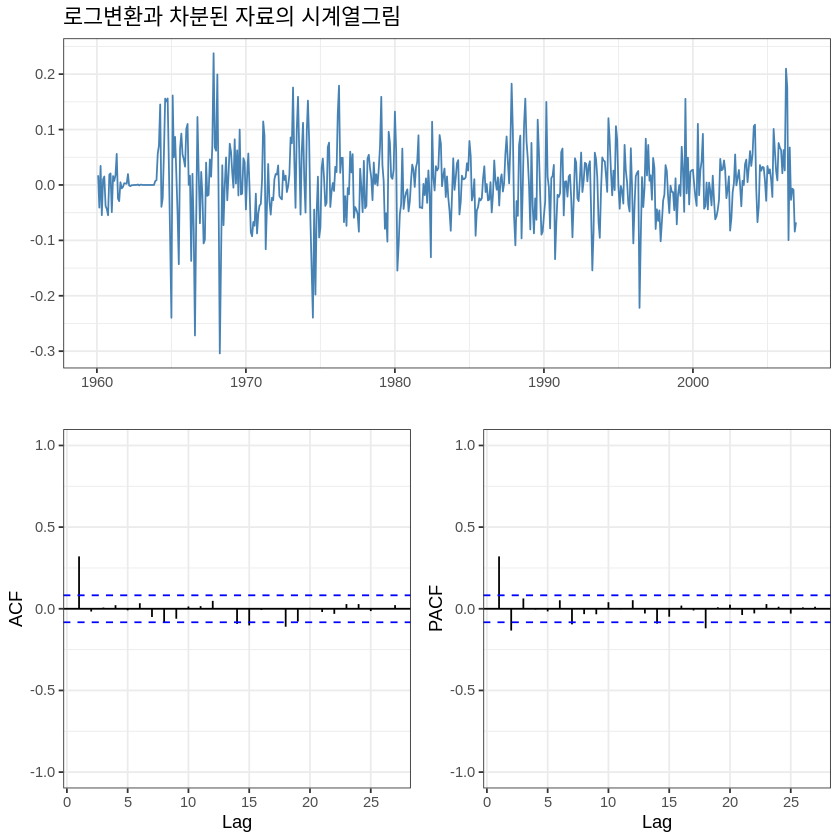

In [188]:
tmp.dat[, df1_lnz := c(0, diff(lnz))]
dt <- tmp.dat[-1,]

p3 <- ggplot(dt, aes(t, df1_lnz)) + geom_line(col='steelblue') +  xlab("")+ylab('')+ ggtitle('로그변환과 차분된 자료의 시계열그림')+ theme_bw()
p1 <- ggAcf(dt$df1_lnz) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(dt$df1_lnz) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2, layout_matrix = rbind(c(1,1), c(2,3)))

- 차분 후 시계열 그림을 보면 추세는 없고, 평균도 0 인것처럼보인다. 따라서 계절차분은 추가로 필요하지 않아보이며, 상수항 없는 단위근 검정 typr 옵션 nc 를 사용하였다.
- ACF, PACF 는 절단된 형태였다.

In [189]:
adfTest(sdt$df12_lnz, lags = 0, type = "nc")
adfTest(sdt$df12_lnz, lags = 1, type = "nc")
adfTest(sdt$df12_lnz, lags = 2, type = "nc")

Warning message in adfTest(sdt$df12_lnz, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -3.7045
  P VALUE:
    0.01 

Description:
 Sat Dec 11 09:52:49 2021 by user: 


Warning message in adfTest(sdt$df12_lnz, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -5.4112
  P VALUE:
    0.01 

Description:
 Sat Dec 11 09:52:49 2021 by user: 


Warning message in adfTest(sdt$df12_lnz, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -4.9771
  P VALUE:
    0.01 

Description:
 Sat Dec 11 09:52:49 2021 by user: 


- 단위근 검정을 해보아도 모두 기각하여 단위근이 없다는 결론이 나왔다.
- 따라서 추가적인 차분이 필요하지 않겠다.
- 상수항 없는 ARIMA(1,1,1)(0,0,0) 모형을 적합해보았다.

In [190]:
fit2 = arima(tmp.dat$lnz, order = c(1,1,1), seasonal = list(order = c(0,0,0), period = 0))
fit2


Call:
arima(x = tmp.dat$lnz, order = c(1, 1, 1), seasonal = list(order = c(0, 0, 0), 
    period = 0))

Coefficients:
          ar1     ma1
      -0.0083  0.3825
s.e.   0.1007  0.0912

sigma^2 estimated as 0.003628:  log likelihood = 782.85,  aic = -1559.69

##### (4) (2),(3)번 모형 중 어떤 모형일 더 적절한지 설명하여라.

In [191]:
summary(fit)
coeftest(fit)


Call:
arima(x = tmp.dat$lnz, order = c(0, 1, 1), seasonal = list(order = c(0, 0, 0), 
    period = 0))

Coefficients:
         ma1
      0.3756
s.e.  0.0385

sigma^2 estimated as 0.003628:  log likelihood = 782.84,  aic = -1561.69

Training set error measures:
                      ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.003341946 0.06017865 0.04310712 0.04698529 0.6404858 0.9274756
                     ACF1
Training set -0.004096904


z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ma1 0.375553   0.038466  9.7632 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- (2)에서 적합한 모형이다.
- ARIMA(0.1.1)(0.0.0)

In [192]:
summary(fit2)
coeftest(fit2)


Call:
arima(x = tmp.dat$lnz, order = c(1, 1, 1), seasonal = list(order = c(0, 0, 0), 
    period = 0))

Coefficients:
          ar1     ma1
      -0.0083  0.3825
s.e.   0.1007  0.0912

sigma^2 estimated as 0.003628:  log likelihood = 782.85,  aic = -1559.69

Training set error measures:
                      ME      RMSE        MAE        MPE      MAPE      MASE
Training set 0.003353127 0.0601783 0.04311008 0.04713204 0.6405084 0.9275395
                     ACF1
Training set -0.002840927


z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ar1 -0.0082743  0.1006792 -0.0822    0.9345    
ma1  0.3824808  0.0911940  4.1941 2.739e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


- (3)에서 적합한 모형이다. 
- ARIMA(1,1,1)(0,0,0)

- AIC값은 (2)에서 적합한 모형이 더 작다.
- log likelihood 값은 (3)에서 적합한 모형이 더 크다.
- (3)모형을 선택하였다.

##### (5) (4)에서 선택한 모형을 이용하여 잔차검정을 시행하여라.

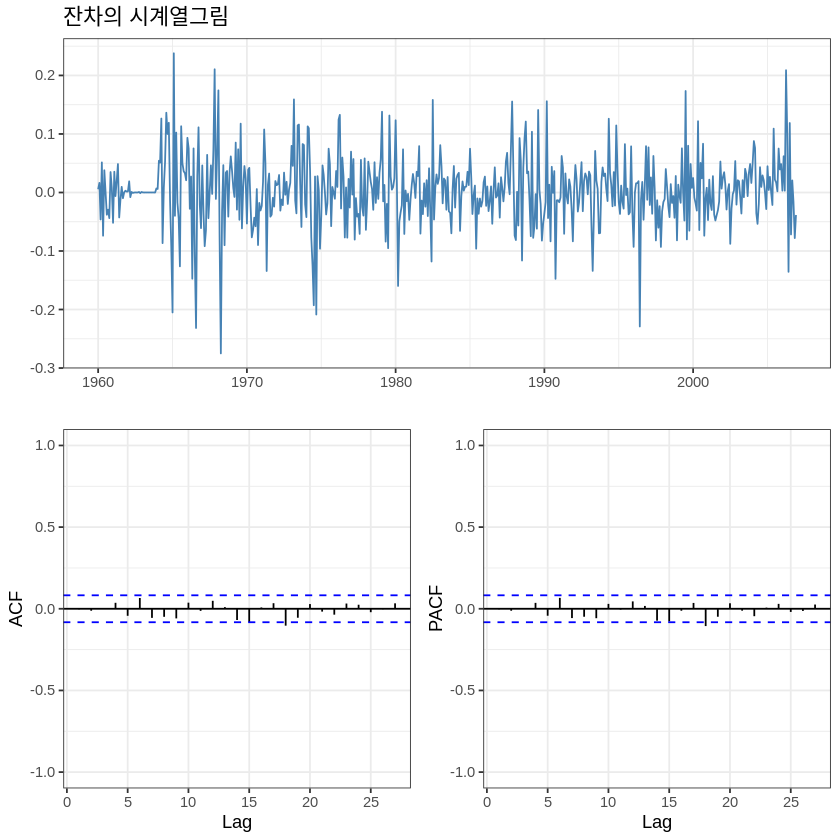

In [193]:
tmp.dat[, res2 := as.numeric(resid(fit2))]
p3 <- ggplot(tmp.dat, aes(t, res2)) +  geom_line(col='steelblue') + xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+ theme_bw()
p1 <- ggAcf(tmp.dat$res2) +  theme_bw() + ylim(-1,1) +  theme(plot.title = element_blank())
p2 <- ggPacf(tmp.dat$res2) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,  layout_matrix = rbind(c(1,1), c(2,3)))

- 잔차 plot이 잘 흩어져 있는 모습이다.
- ACF와 PACF가 모두 유의하지 않은 모습이었다. 백색소음!

In [194]:
dwtest(tmp.dat$res2~1)


	Durbin-Watson test

data:  tmp.dat$res2 ~ 1
DW = 2.0048, p-value = 0.5229
alternative hypothesis: true autocorrelation is greater than 0


- 더빈왓슨 검정 결과 p값은 유의하지 않아 자기상관관계가 없다고 할 수 있다.

In [195]:
LjungBox(fit2, lags=seq(6,24,6))# 잔차의 포트맨토검정  

,lags,statistic,df,p-value
,6,4.36822,4,0.35846040
,12,11.78529,10,0.29968310
,18,25.47615,16,0.06185941
,24,29.64746,22,0.12728780


- 잔차의 포트맨토 검정 결과도 모두 유의하지 않은 모습이었다.

In [196]:
shapiro.test(tmp.dat$res2) 


	Shapiro-Wilk normality test

data:  tmp.dat$res2
W = 0.96373, p-value = 1.409e-10


- 하지만 정규성 가정을 만족하지 않은 모습이다.

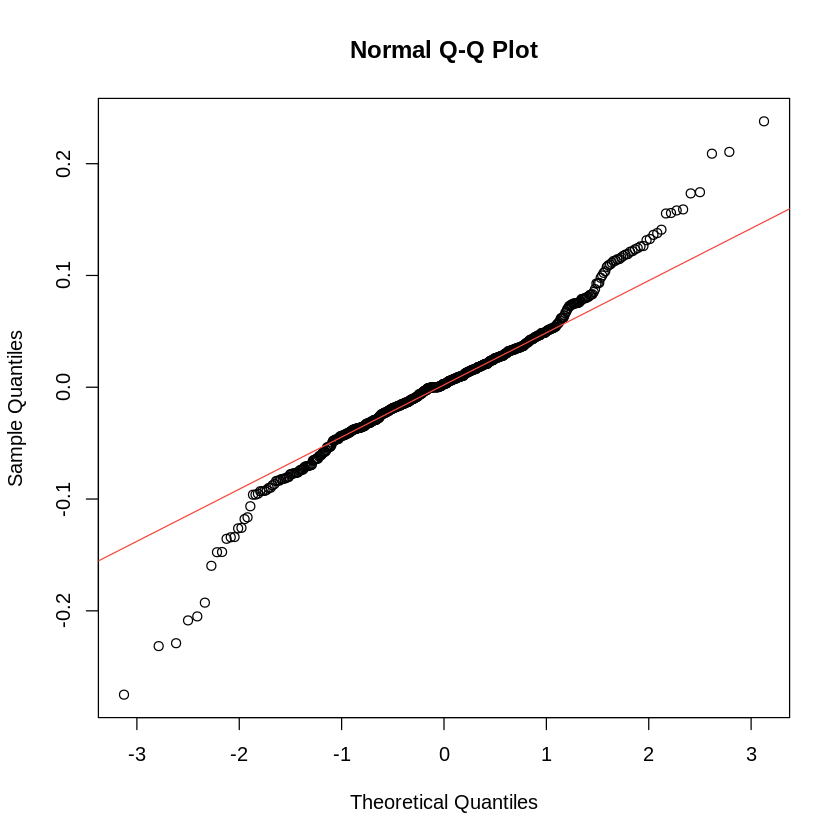

In [197]:
qqnorm(tmp.dat$res2)
qqline(tmp.dat$res2, col = 2)

##### (6) 2007년과 2008년 데이터를 예측하여라

$pred
Time Series:
Start = 565 
End = 588 
Frequency = 1 
 [1] -0.018040481 -0.002050201  0.003116094  0.004786935  0.005328969
 [6]  0.005506471  0.005566252  0.005588017  0.005597505  0.005603029
[11]  0.005607272  0.005611102  0.005614798  0.005618451  0.005622090
[16]  0.005625725  0.005629358  0.005632991  0.005636624  0.005640256
[21]  0.005643889  0.005647521  0.005651154  0.005654786

$se
Time Series:
Start = 565 
End = 588 
Frequency = 1 
 [1] 0.06081135 0.06393668 0.06426446 0.06430197 0.06430699 0.06430787
 [7] 0.06430807 0.06430813 0.06430815 0.06430816 0.06430816 0.06430816
[13] 0.06430816 0.06430816 0.06430816 0.06430816 0.06430816 0.06430816
[19] 0.06430816 0.06430816 0.06430816 0.06430816 0.06430816 0.06430816

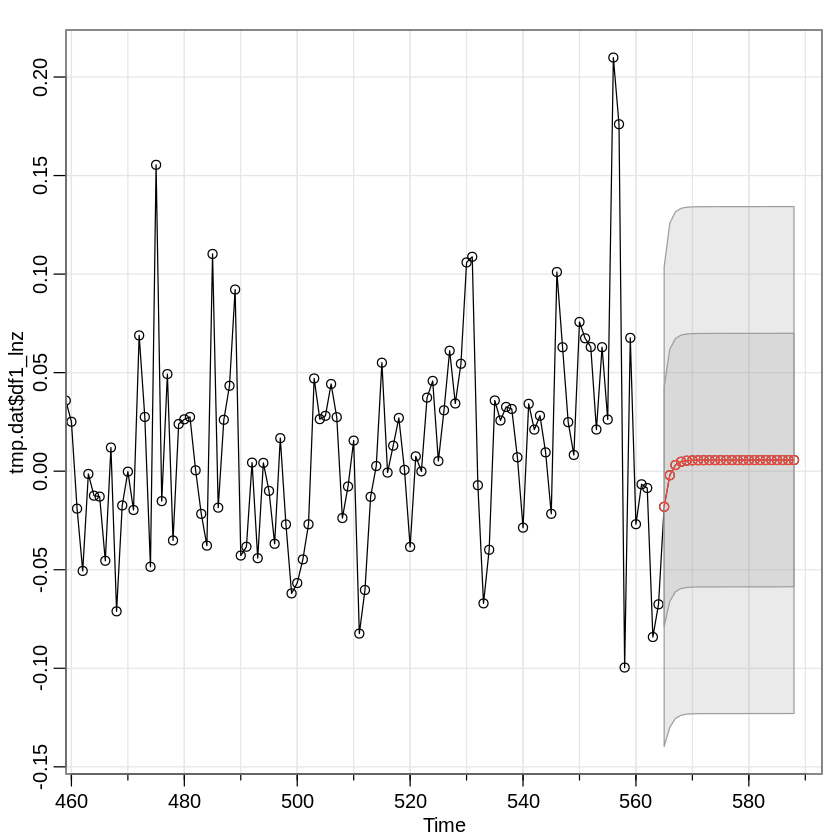

In [198]:
sarima.for(tmp.dat$df1_lnz, 24, 1,1,1) 

- 2007년과 2008년 데이터를 예측해보았다.
- 평균 근처에서 잘 예측되는 모습이다.

#### 2. 사용할 데이터 : hsales

##### (1) 변수변환이 필요한지를 설명하고 , 필요하다면 적절한 변수 변환을 하여라 

In [205]:
z<-as.numeric(hsales)
length(z)

[1] 275

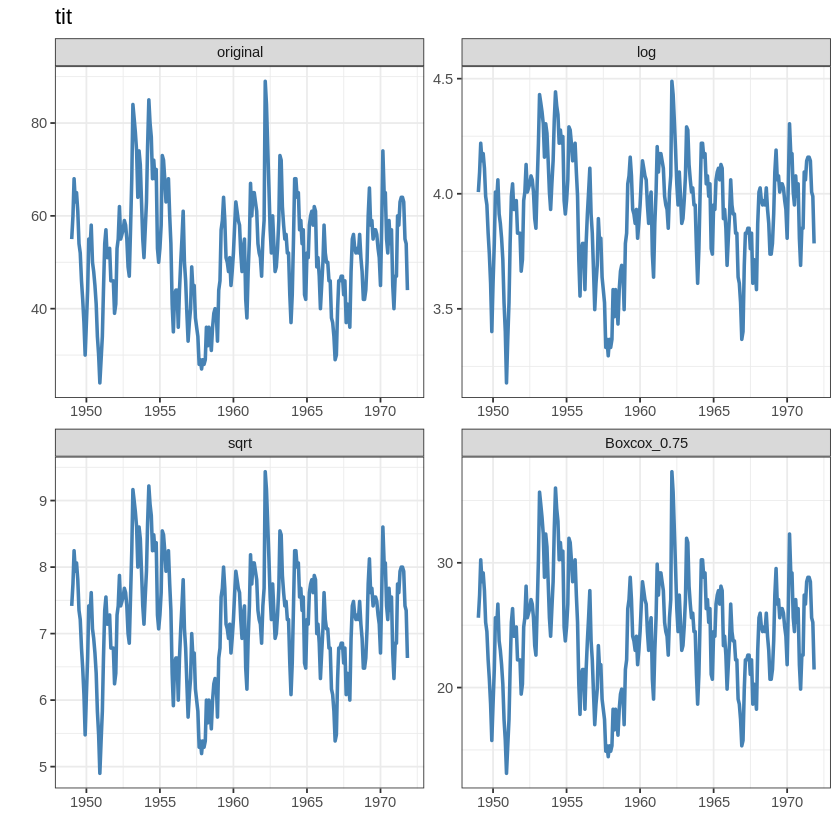

In [206]:
tmp.dat <- data.table(t=seq.Date(as.Date("1949-01-01"),by='month',length.out=275),
  original=z, log = log(z), sqrt = sqrt(z),
  Boxcox_0.75 = BoxCox(z,lambda= BoxCox.lambda(z, method='loglik')) 
)
melt.tmp <- melt(tmp.dat, id=1)
ggplot(melt.tmp, aes(t,value)) + 
  geom_line(col='steelblue', lwd=1) +
  xlab("")+ylab("")+
  ggtitle("tit")+
  theme_bw()+
  facet_wrap(.~variable, nrow = 2, scales = "free")

- 변수 변환은 필요 없어보인다.
- 추세가 존재하지도 않고 이분산성도 보이지 않기 때문이다.

##### (2) 데이터가 정상시계열인가 ? 아니면 적절한 차분을 통해 정상시계열로 변환하여라 .

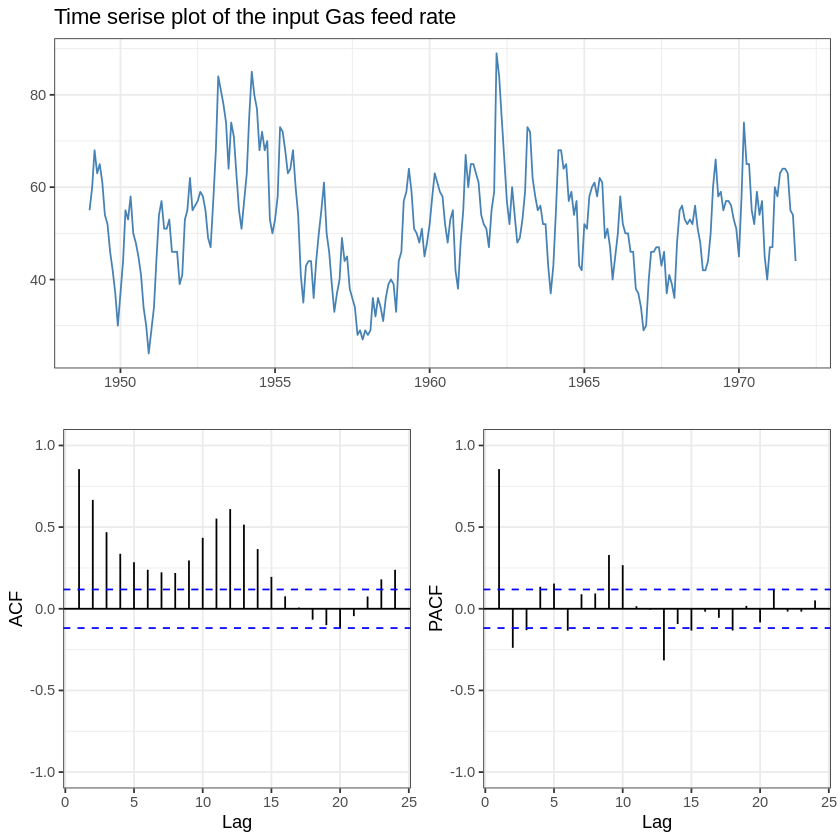

In [207]:
p3 <- ggplot(tmp.dat, aes(t, original)) +  geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('Time serise plot of the input Gas feed rate')+
  theme_bw()
p1 <- ggAcf(tmp.dat$original) +  theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())
p2 <- ggPacf(tmp.dat$original) + theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1), c(2,3)))

- 추세가 없어보임, 평균이 60인 것 같다.
- ACF가 빠르게 감소하고 있는 것처럼 보이면서 산처럼 솟은 곳이 보여 계절차분을 해도 되겠다.
- PACF 1 이후 유의한 부분이 보인다. 아마 ACF에서 판단한 것처럼 계절차분이 필요하기 때문이지 않을까? 
- 혹은 ACF가 빠르게 감소한다고 보고, PACF를 1시차에서 절단된다고 봐서 AR(1) 모형을 적합해보는 방법도 고려해봤다.

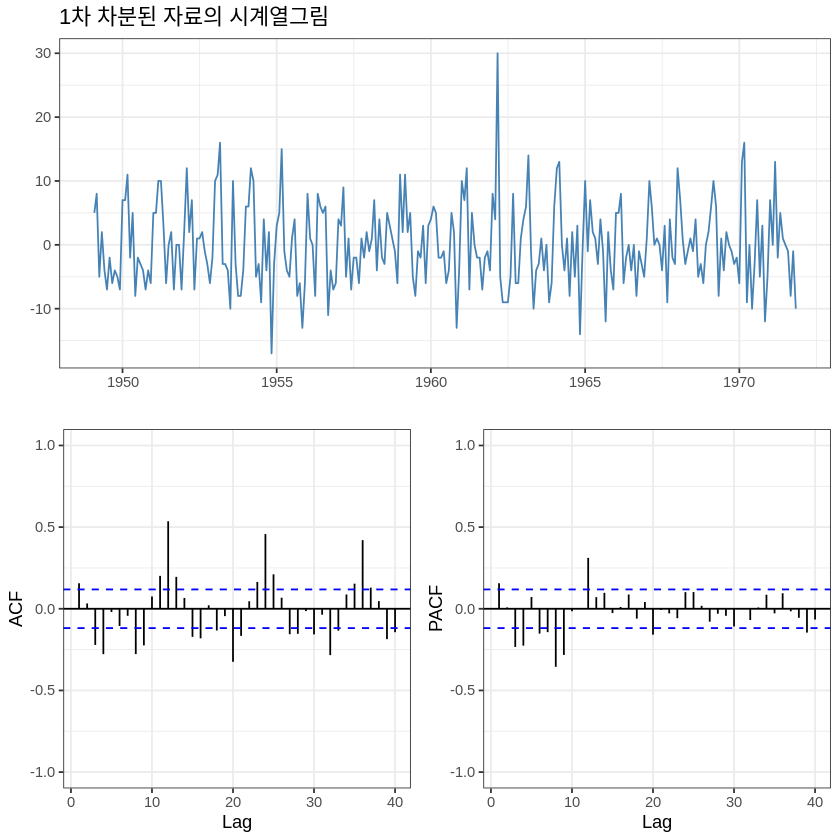

In [215]:
tmp.dat[, df1_z := c(0, diff(original))]
dt <- tmp.dat[-1,]
p3 <- ggplot(dt, aes(t, df1_z)) +  geom_line(col='steelblue') + xlab("")+ylab('')+ ggtitle('1차 차분된 자료의 시계열그림')+ theme_bw()
p1 <- ggAcf(dt$df1_z, lag.max = 40) +   theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(dt$df1_z, lag.max = 40) +  theme_bw() +ylim(-1,1) + theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,   layout_matrix = rbind(c(1,1),    c(2,3)))

- 위에서 예측한대로 계절주기가 보이는 것 같다. 즉, 우똑 솟은 유의한 값 양쪽으로도 유의한 모습을 보이고 있었다.
- ARIMA(1,0,0)(1,0,0)_12 모형이 적절하지 않을까?
- 시계열 plot에서 일단 계절성이 뚜렷하고, PACF도 계절 주기에 해당되는 시차에서 서서히 감소하고 있어 계절차분이 추가로 필요함을 알 수 있었다.

In [221]:
adfTest(dt$df1_z, lags = 0, type = "nc")
adfTest(dt$df1_z, lags = 1, type = "nc")
adfTest(dt$df1_z, lags = 2, type = "nc")

Warning message in adfTest(dt$df1_z, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -14.0192
  P VALUE:
    0.01 

Description:
 Sat Dec 11 10:44:06 2021 by user: 


Warning message in adfTest(dt$df1_z, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -10.5881
  P VALUE:
    0.01 

Description:
 Sat Dec 11 10:44:06 2021 by user: 


Warning message in adfTest(dt$df1_z, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -11.1907
  P VALUE:
    0.01 

Description:
 Sat Dec 11 10:44:06 2021 by user: 


- 단위근 검정을 해보니 p 값이 모두 작아 모두 기각하였으며, 단위근이 없다는 결론이 나왔다.

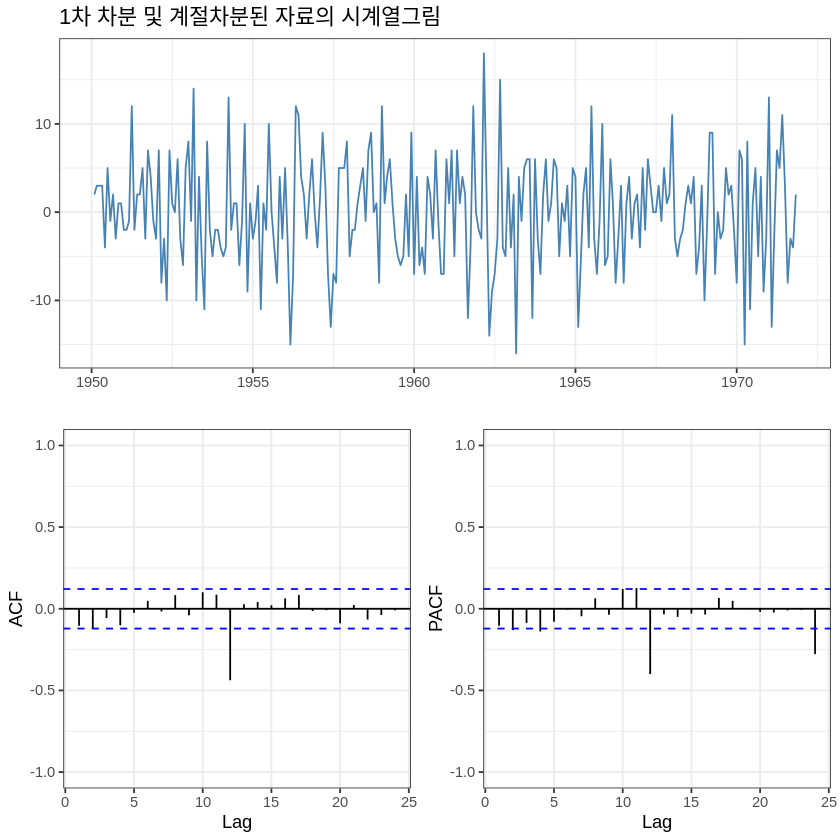

In [222]:
dt[, df12_df1_lnz := c(rep(0,12), diff(df1_z,12))]
sdt <- dt[-(1:12)]
p3 <- ggplot(sdt, aes(t, df12_df1_lnz)) + geom_line(col='steelblue') +xlab("")+ylab('')+ ggtitle('1차 차분 및 계절차분된 자료의 시계열그림')+theme_bw()
p1 <- ggAcf(sdt$df12_df1_lnz) + theme_bw() + ylim(-1,1) + theme(plot.title = element_blank())
p2 <- ggPacf(sdt$df12_df1_lnz) +  theme_bw() +ylim(-1,1) +theme(plot.title = element_blank())
grid.arrange(p3, p1, p2, nrow = 2,   layout_matrix = rbind(c(1,1), c(2,3)))

- 1차 차분 및 계쩔차분된 시계열 plot은 정상적으로 보인다.

In [211]:
adfTest(sdt$df1_df12_lnz, lags = 0, type = "nc")
adfTest(sdt$df1_df12_lnz, lags = 1, type = "nc")
adfTest(sdt$df1_df12_lnz, lags = 2, type = "nc")

Warning message in adfTest(sdt$df1_df12_lnz, lags = 0, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -17.9245
  P VALUE:
    0.01 

Description:
 Sat Dec 11 10:08:12 2021 by user: 


Warning message in adfTest(sdt$df1_df12_lnz, lags = 1, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -13.636
  P VALUE:
    0.01 

Description:
 Sat Dec 11 10:08:12 2021 by user: 


Warning message in adfTest(sdt$df1_df12_lnz, lags = 2, type = "nc"):
“p-value smaller than printed p-value”



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 2
  STATISTIC:
    Dickey-Fuller: -11.3107
  P VALUE:
    0.01 

Description:
 Sat Dec 11 10:08:12 2021 by user: 


- 단위 검정 결과 모두 기각하여 단위근이 없다는 결과가 나왔다.
- 분산이 안정화되어 있고, 추세 및 계절성도 없어 정상시계열로 변환된 것 같다.

##### (3) 모형을 식별하여라 . (2 개 이상의 모형 고려 )( 형태 : ARIMA( p.d.q )(P,D,Q)s )

ARIMA(0,1,0)(1,1,1)_12

ARIMA(0,1,0)(1,1,0)_12

##### (4) (3) 에서 고려한 모형을 적합하여라 . ( 형태 : ARIMA( p.d.q )(P,D,Q)s, 모수추정값 )

In [224]:
### ARIMA(0,1,1)(0,1,1)_12
fit1 = arima(sdt$df1_z, order = c(0,1,0), seasonal = list(order = c(1,1,1), period = 12))
fit1


Call:
arima(x = sdt$df1_z, order = c(0, 1, 0), seasonal = list(order = c(1, 1, 1), 
    period = 12))

Coefficients:
        sar1     sma1
      0.0677  -1.0000
s.e.  0.0658   0.0614

sigma^2 estimated as 44.52:  log likelihood = -843.61,  aic = 1693.22

- 차분한 값이니, order에는 0,0,1을 대입하여 모형 적합을 실시하였다.
- AIC 값은 3339.78이 나왔다.

In [112]:
## ARIMA(1,1,0)(0,1,1)_12
fit3 = arima(sdt$df1_z, order = c(0,0,1))
fit3


Call:
arima(x = sdt$df1_z, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.6625    -0.0814
s.e.  0.0254     0.5379

sigma^2 estimated as 57.87:  log likelihood = -1903.61,  aic = 3813.22

##### (5) (4) 에서 적합된 결과를 이용하여 더 좋은 모형을 선택하여라 .

- ARIMA(1,1,0)(0,1,1)_12
- 모형의 AIC 값이 가장 작다.

##### (6) (5) 에서 선택한 모형을 이용하여 잔차검정을 시행하여라 .

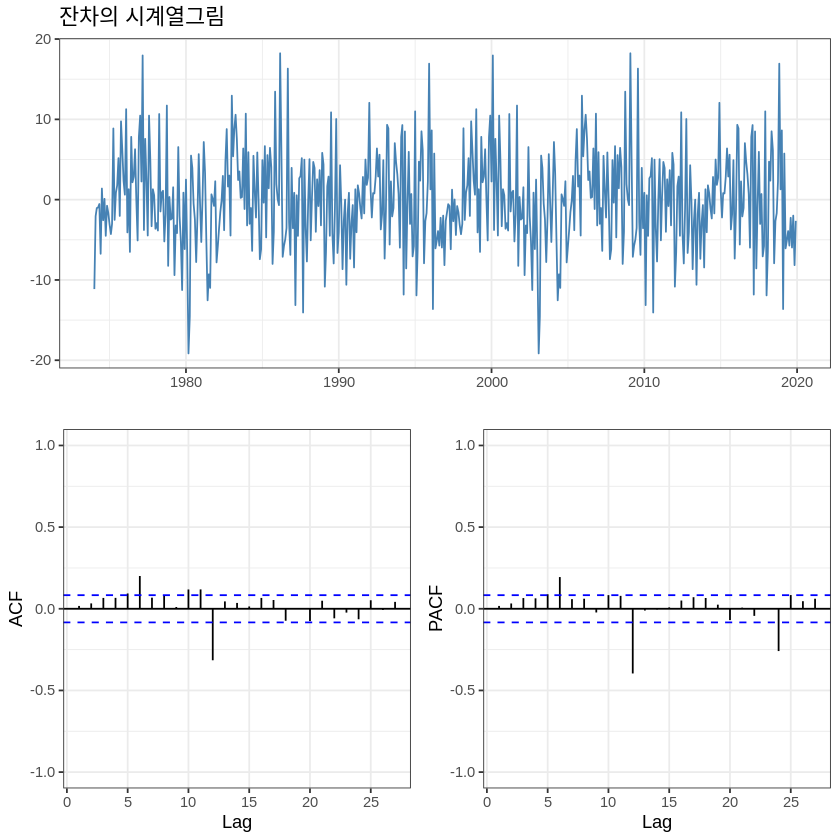

In [76]:
sdt[, res3 := as.numeric(resid(fit3))]

p3 <- ggplot(sdt, aes(t, res3)) + geom_line(col='steelblue') +
  xlab("")+ylab('')+ ggtitle('잔차의 시계열그림')+ theme_bw()

p1 <- ggAcf(sdt$res3) + theme_bw() + ylim(-1,1) +
  theme(plot.title = element_blank())

p2 <- ggPacf(sdt$res3) + theme_bw() +ylim(-1,1) +
  theme(plot.title = element_blank())

grid.arrange(p3, p1, p2, nrow = 2,
             layout_matrix = rbind(c(1,1), c(2,3)))

,lags,statistic,df,p-value
,6,22.20338,4,1.825755e-04
,12,32.62324,10,3.150648e-04
,18,39.96759,16,7.871188e-04
,24,61.09737,22,1.535508e-05



	Shapiro-Wilk normality test

data:  sdt$res
W = 0.99469, p-value = 0.053


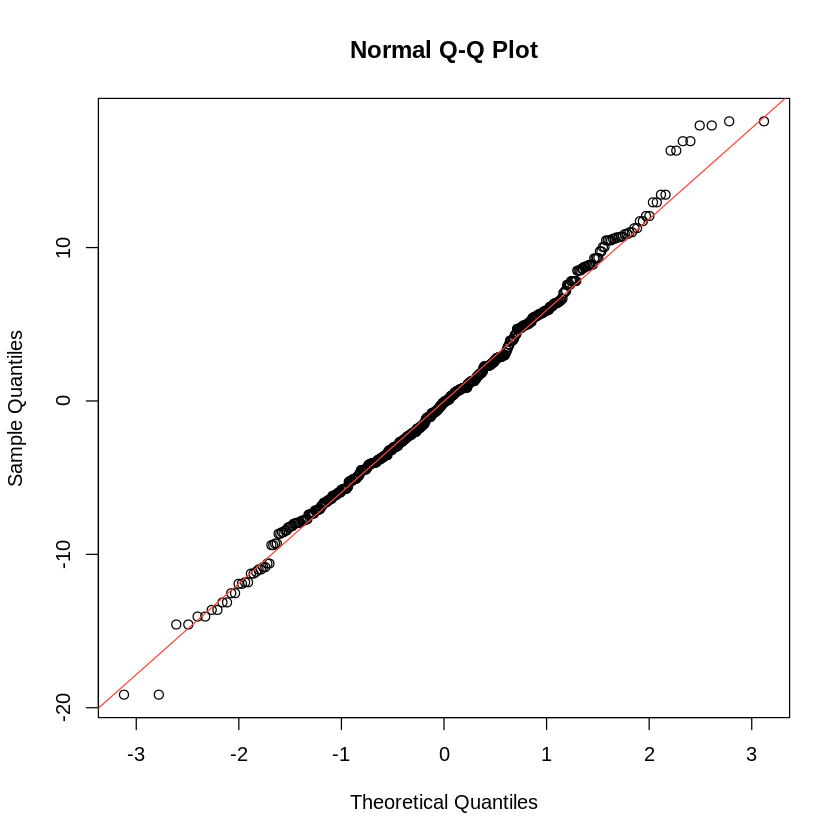

In [82]:
LjungBox(fit1, lags=seq(6,24,6))# 잔차의 포트맨토검정  

shapiro.test(sdt$res) 
qqnorm(sdt$res)
qqline(sdt$res, col = 2)

- 잔차들의 분포가 정규성 가정을 만족하는 것을 알 수 있었다.

##### (7) 다음 2년간의 값을 예측하여라 .

$pred
Time Series:
Start = 276 
End = 299 
Frequency = 1 
 [1] 42.54986 42.50700 42.46415 42.42129 42.37843 42.33557 42.29271 42.24985
 [9] 42.20699 42.16413 42.12127 42.07841 42.03555 41.99269 41.94983 41.90697
[17] 41.86411 41.82125 41.77839 41.73553 41.69267 41.64981 41.60695 41.56409

$se
Time Series:
Start = 276 
End = 299 
Frequency = 1 
 [1]  6.334150  9.610339 12.024798 14.029715 15.781954 17.358203 18.802776
 [8] 20.144020 21.401371 22.588843 23.716935 24.793752 25.825710 26.817988
[15] 27.774838 28.699804 29.595877 30.465605 31.311184 32.134520 32.937282
[22] 33.720938 34.486792 35.236004

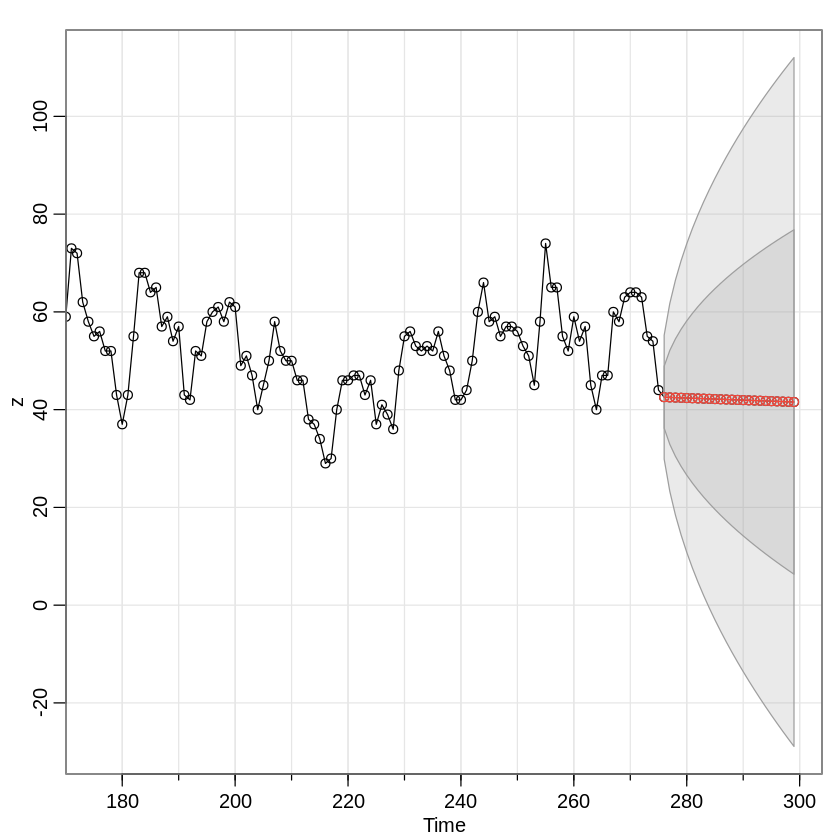

In [114]:
sarima.for(z, 24, 0,1,1)

$pred
Time Series:
Start = 553 
End = 576 
Frequency = 1 
 [1] -4.33089907 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428
 [7] -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428
[13] -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428
[19] -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428 -0.08143428

$se
Time Series:
Start = 553 
End = 576 
Frequency = 1 
 [1] 7.607315 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226
 [9] 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226
[17] 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226 9.125226

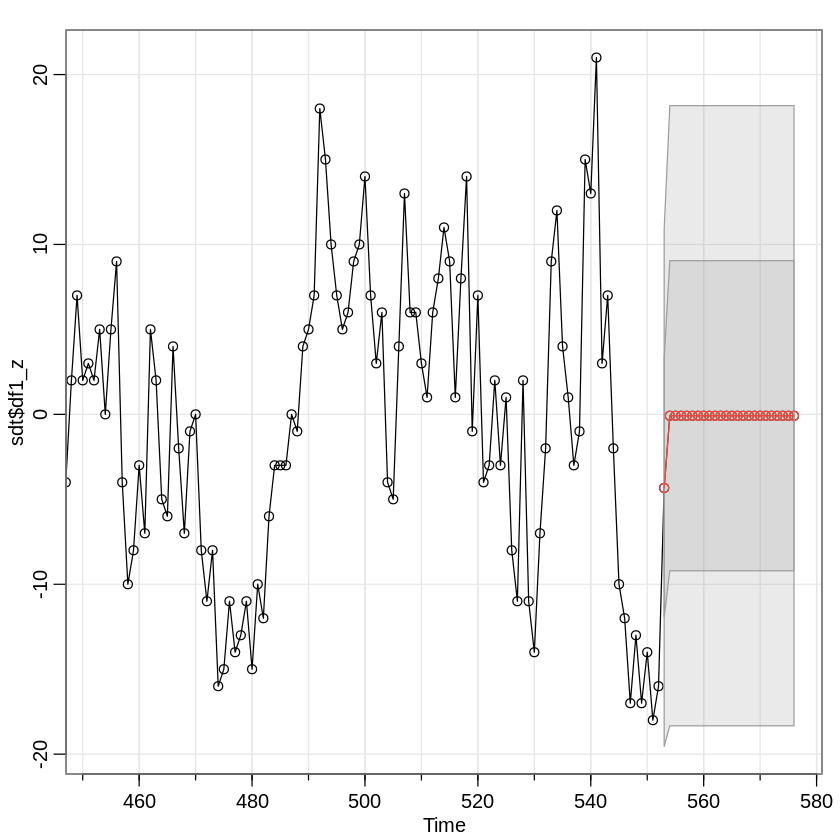

In [115]:
sarima.for(sdt$df1_z, 24, 0,0,1) # 차분했던 거 써줬을때